In [ ]:
pip install gensim # pour le doc2vec

In [48]:
# --- CONFIGURATION OF COLORS ---

GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"

In [47]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from urllib.parse import urlparse
import time
import random
import csv
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter
import numpy as np
#nltk.download('punkt_tab') #: to uncomment if not already downloaded
#nltk.download('stopwords') #: to uncomment if not already downloaded
#nltk.download('wordnet')    #: to uncomment if not already downloaded
#nltk.download('omw-1.4')    #: to uncomment if not already downloaded

In [46]:
HEADERS = {'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}

session = requests.Session()
session.headers.update(HEADERS)

def fetch_verify_url(url):
    try:
        response = session.get(url, timeout=10)
        if response.status_code != 200:
            print(f"{RED}Failed to fetch {url} with status code {response.status_code}{RESET}")
            return None

        time.sleep(random.uniform(0.5,1.5))
        return response

    except requests.RequestException as e:
        print(f"{RED}Error fetching {url}: {e}{RESET}")
        return None


In [49]:
def to_soup(url):
    response = fetch_verify_url(url)
    if response:  # If the response is not none, the function return the beautiful soup object
        return BeautifulSoup(response.text, 'html.parser') 
    else:
        return None

In [8]:
def create_filepath():

    user_filename = input("Enter the name of the file to save (e.g. : test) : ").strip() #strip deletes spaces before and after the string
    
    if not user_filename : 
        user_filename = "test"
    
    if not user_filename.endswith('.csv'): # Verify if the filename ends with .csv
        user_filename += '.csv' # Append .csv if not present
    filename = os.path.join("data", user_filename) # Construct the full file path

    # Create directory if not exists
    directory = os.path.dirname(filename)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
        print(f"{GREEN}Created directory : {os.path.abspath(directory)}{RESET}") # Full path info
    print(f'{BLUE}Output will be saved to : "{filename}_raw_html"{RESET}')

    if os.path.exists(filename):
        print(f"{BLUE}Note : The file is overwritten{RESET}") 
    
    return filename

In [6]:
def get_html_content(links, max=10):
    content = []
    failed_links = []
    #filename = create_filepath()

    for link in links[:max]:
        response = fetch_verify_url(link)
        if response:
            content.append({'url': link, 'html': response.text})
        else:
            failed_links.append(link)

    print(f"{GREEN}Fetched: {len(content)} {BLUE}|{RED} Failed: {len(failed_links)}{RESET}")

    return content, failed_links 

In [7]:
def save_to_csv(data, filename):
    if not data:
        print(f"{RED}No data to save.{RESET}")
        return

    # Get the keys from the first dictionary for the CSV header from get_html_content
    fieldnames = data[0].keys() # Detection of the existing colons in the data file
    
    try:
        with open(filename, 'w', newline='', encoding='utf-8') as f: # Opens the csv file as utf-8
            writer = csv.DictWriter(f, fieldnames=fieldnames, quoting=csv.QUOTE_ALL) # Initialising a writer to write the dictionary into the csv file
            writer.writeheader() # writes the colons headers
            writer.writerows(data) # writes the rows
        print(f"{GREEN}Success! Data saved to: {os.path.abspath(filename)}{RESET}")
        
    except Exception as e:
        print(f"{RED}Error saving file: {e}{RESET}")

In [8]:
def get_files_name() :
    print("Files in data directory :")
    print(os.listdir("data"))

# ------------------------------------------------------------------------------------------------------------------------------

In [50]:
csv_path = r"C:\Users\Violaine\OneDrive\Ecole\Master 1\Web mining\Projet Web Mining\Projet_Web_Mining\MGB\MBG_raw_html.csv"
MBG_content = pd.read_csv(csv_path)

In [51]:
from bs4 import BeautifulSoup
from dateutil import parser
import re

def extract_date_from_html(html):
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(separator=" ", strip=True)

    date_patterns = [
        # Detect dates like : September 17, 2024 / Sep 17, 2024
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
        r'Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|'
        r'Dec(?:ember)?)\s\d{1,2},\s\d{4}\b',

        # Detect dates like : September 17 2024 
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
        r'Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|'
        r'Dec(?:ember)?)\s\d{1,2}\s\d{4}\b',

        # Detect dates like : 17 September 2024
        r'\b\d{1,2}\s(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|'
        r'Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|'
        r'Nov(?:ember)?|Dec(?:ember)?)\s\d{4}\b',

        # Detect dates like : 2024-09-17 (ISO)
        r'\b\d{4}-\d{2}-\d{2}\b',

        # Detect dates like : 09/17/2024 and 9/17/24 
        r'\b\d{1,2}/\d{1,2}/\d{2,4}\b'
    ]

    for pattern in date_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)  # Find all date strings in the text that match one of the date pattern
        for match in matches:  
            try:  # Try to convert the matched string into a date object to have all the dates with the same format
                date = parser.parse(match, fuzzy = False)  # Parse convert the match object into a datetime with a strict parsing (fuzzy = False -> takes only set apart dates, not dates in the text) 
                if 1990 <= date.year <= 2030:  # Keep only dates in a reasonable year range
                    return date
            except:
                continue  # If parsing fails, ignore this match and move to the next match

    return None


In [52]:
def MBG_content_date_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'html' not in df.columns:  # Verify that the html column exists
        raise ValueError(f"The html column is missing in: {input_csv}")

    # Extract date from the html column
    df['date'] = df['html'].apply(extract_date_from_html)

    # Keep columns in the desired order with the 3 columns
    df = df[['url', 'date', 'html']]

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Create a new csv file

    return df

In [53]:
content_date_MBG_csv = MBG_content_date_csv_file(csv_path, "MBG_content_date.csv")

In [54]:
def get_MBG_corpus(html):
    soup = BeautifulSoup(html, "html.parser")
    
    paragraphs = [p.get_text(separator=" ", strip=True) for p in soup.find_all("p") if len(p.get_text(strip=True)) > 10]
    
    text = " ".join(paragraphs)

    return text

In [55]:
def MBG_corpus_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'html' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The html column is missing in: {input_csv}")

    df['corpus_text'] = df['html'].apply(get_MBG_corpus)  # Cleans the html column
    df = df[['url', 'date', 'corpus_text']]  # Keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

In [56]:
corpus_MBG_csv = MBG_corpus_csv_file("MBG_content_date.csv", "MBG_corpus.csv")

In [57]:
def clean_html(html):
    soup = BeautifulSoup(html, 'html.parser')

    for tag in soup(['script', 'style', 'noscript']):  # Supress any unessecary tags
        tag.decompose()

    text = soup.get_text(separator=' ', strip=True)  # Collect all visible text
    text = re.sub(r'\s+', ' ', text)  # Supress any unecessary spaces

    return text

In [58]:
def clean_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'corpus_text' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The corpus column is missing in: {input_csv}")

    df['cleaned_text'] = df['corpus_text'].apply(clean_html)  # Cleans the html column
    df = df[['url', 'date', 'cleaned_text']]  # Keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

In [59]:
cleaned_MBG_csv = clean_csv_file("MBG_corpus.csv", "cleaned_MBG_corpus.csv")

In [87]:
def normalize_html(text):
    text = text.lower()  # Convert all characters to lowercase
    text = re.sub(r'\[\d+\]', ' ', text)  # Remove reference markers like [1], [23], etc.
    text = re.sub(r'[^a-z\s]', ' ', text)  # Keep only English letters and spaces (remove ponctuation, numbers, and everything that is not a letter)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip() 

In [88]:
def normalize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the cleaned text as the input

    if 'cleaned_text' not in df.columns:  # Verify that the cleaned text colon exists
        raise ValueError(f"The cleaned text is missing in: {input_csv}")

    df['normalized_text'] = df['cleaned_text'].apply(normalize_html)  # normalize the cleaned text
    df = df[['url', 'date', 'normalized_text']]  # keep the url and normalized text 

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

In [89]:
normalized_MBG_csv = normalize_csv_file("cleaned_MBG_corpus.csv", "normalized_MBG_corpus.csv")

In [125]:
stop_words = set(stopwords.words('english'))  # Load English stopwords
stop_words = list(set(stopwords.words('english'))) + ["'s"]  # Load English stopwords with an "s" at their ending

custom_stopwords = { "also", "like"}

#stem = nltk.stem.SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def tokenize_html(text):
    tokens = nltk.word_tokenize(text)  # Transform the text into a list of words
    tokens = [token for token in tokens if token not in stop_words]  # remove stopwords
    #tokens = [stem.stem(token) for token in tokens]  # apply stemming (racinisation)

    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # apply lemmatization
    #tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]

    tokens = [t for t in tokens if len(t) > 1]  # Remove very short or meaningless tokens 
    tokens = [t for t in tokens if t not in custom_stopwords]  #-> seulement si on a une custom list
    return tokens

In [126]:
def tokenize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the normalized text as the input

    if 'normalized_text' not in df.columns:  # Verify that the normalized text colon exists
        raise ValueError(f"The normalized text is missing in: {input_csv}")

    df['tokenized_text'] = df['normalized_text'].apply(tokenize_html)  # cleans the html colon
    df = df[['url', 'date', 'tokenized_text']]  # keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

In [127]:
tokenized_MBG_csv = tokenize_csv_file("normalized_MBG_corpus.csv", "tokenized_MBG_corpus.csv")

# ----------------------------------------------------------------------------------------------------------------------------------------------------------

In [128]:
def build_term_document_matrix(documents, min_doc_freq=2, max_doc_freq=None):
    # Step 1: Build a vocabulary (unique terms across all documents)
    vocabulary = set(token for tokens in documents.values() for token in tokens)  # The vocabulary contains all tokens appearing in the corpus. Each token is listed only once, even if it appears multiple times.

    # Step 2: Count term frequencies for each document
    term_frequencies = {doc: Counter(tokens) for doc, tokens in documents.items()}  # The dictionnary has the name of a document as a key and a counter of token frequency as value

    # Step 3: Construct the term-document matrix (a list of dictionnaries that is transform into pandas dataframe where each column corresponds to a token, each row to a document. Each dictionnary has a token as key and a list of the frequency of its number of appears in all documents as value)
    td_matrix = pd.DataFrame(
        {term: [term_frequencies[doc].get(term, 0) for doc in documents] for term in vocabulary},
        index = documents.keys())  

    # Step 4: Filter terms that appear in fewer / more than x documents
    document_frequency = (td_matrix > 0).sum(axis=0)  # Document frequency counts in how many documents each token appears

    if min_doc_freq is not None:
        td_matrix = td_matrix.loc[:, document_frequency >= min_doc_freq]  # We only keep tokens if they appears a minimum of times. This removes very rare tokens that may not be informative.

    if max_doc_freq is not None:
        document_frequency = (td_matrix > 0).sum(axis=0)
        td_matrix = td_matrix.loc[:, document_frequency <= max_doc_freq]  # We only keep tokens if they appears less than a maximum of times. This removes very common tokens that may be uninformative.

    vocabulary = td_matrix.columns.tolist()  # Update the vocabulary to include only the tokens kept after filtering.

    return td_matrix, vocabulary

In [129]:
tokenized_dict = dict(zip(tokenized_MBG_csv['url'], tokenized_MBG_csv['tokenized_text']))  # We transform the csv file with the tokenized text into a dictionnary to make it feet the function above seen in class

In [130]:
MBG_td_matrix, MBG_vocab = build_term_document_matrix(tokenized_dict, min_doc_freq=2, max_doc_freq=60)

print(MBG_vocab[:20])
print(MBG_td_matrix)

['beyond', 'middle', 'low', 'felt', 'formulated', 'reason', 'full', 'self', 'reduce', 'turn', 'grab', 'made', 'throughout', 'shop', 'including', 'missed', 'included', 'got', 'journey', 'three']
                                                    beyond  middle  low  felt  \
https://www.mindbodygreen.com/articles/why-wome...       1       0    1     0   
https://www.mindbodygreen.com/articles/journey-...       0       0    0     1   
https://www.mindbodygreen.com/articles/suppleme...       0       0    0     0   
https://www.mindbodygreen.com/articles/longevit...       0       0    0     0   
https://www.mindbodygreen.com/articles/natural-...       0       1    0     0   
https://www.mindbodygreen.com/partner/nike               0       0    0     0   
https://www.mindbodygreen.com/articles/4-health...       0       0    1     0   
https://www.mindbodygreen.com/articles/michelle...       1       0    0     1   
https://www.mindbodygreen.com/articles/associat...       0       1    0     0

## TF-IDF

In [98]:
row_sums = MBG_td_matrix.sum(axis=1)  # Compute the total number of tokens in each document (= sum on the td_matrix's rows)
tf = MBG_td_matrix.div(row_sums, axis=0)  # Compute Term Frequency (TF). Each term count is divided by the total number of tokens in the corresponding document (normalization). This accounts for differences in document length.
df = (MBG_td_matrix > 0).sum(axis=0)  # Compute Document Frequency (DF). For each term (column of the td_matrix), count the number of documents in which the term appears at least once.
N = MBG_td_matrix.shape[0]  # Compute the total number of documents. This corresponds to the number of rows in the td_matrix.
idf = np.log((N) / (df))  # Compute the IDF (Specificity). Terms that appear in many documents receive a lower IDF, while rare terms receive a higher IDF, making them more informative.
tf_idf = tf.mul(idf, axis=1)  # Multiply each item in the tf column by the IDF corresponding so that each term's TF is weighted by its IDF score.
print(tf_idf)

                                                      beyond    middle  \
https://www.mindbodygreen.com/articles/why-wome...  0.002761  0.000000   
https://www.mindbodygreen.com/articles/journey-...  0.000000  0.000000   
https://www.mindbodygreen.com/articles/suppleme...  0.000000  0.000000   
https://www.mindbodygreen.com/articles/longevit...  0.000000  0.000000   
https://www.mindbodygreen.com/articles/natural-...  0.000000  0.003906   
https://www.mindbodygreen.com/partner/nike          0.000000  0.000000   
https://www.mindbodygreen.com/articles/4-health...  0.000000  0.000000   
https://www.mindbodygreen.com/articles/michelle...  0.002804  0.000000   
https://www.mindbodygreen.com/articles/associat...  0.000000  0.013301   
https://www.mindbodygreen.com/articles/3-ways-t...  0.000000  0.000000   

                                                         low      felt  \
https://www.mindbodygreen.com/articles/why-wome...  0.002761  0.000000   
https://www.mindbodygreen.com/article

In [99]:
# To help us visualize, we transform the urls into readable labels
def url_to_label(url):
    last_part = url.rstrip('/').split('/')[-1]  # We only keep the last part of the url
    label = ' '.join([word.capitalize() for word in last_part.replace('-', ' ').replace('_', ' ').split()])  # We delete unwanted element ("_") and replace them by a space. The following letter is set as a capital letter.
    return label

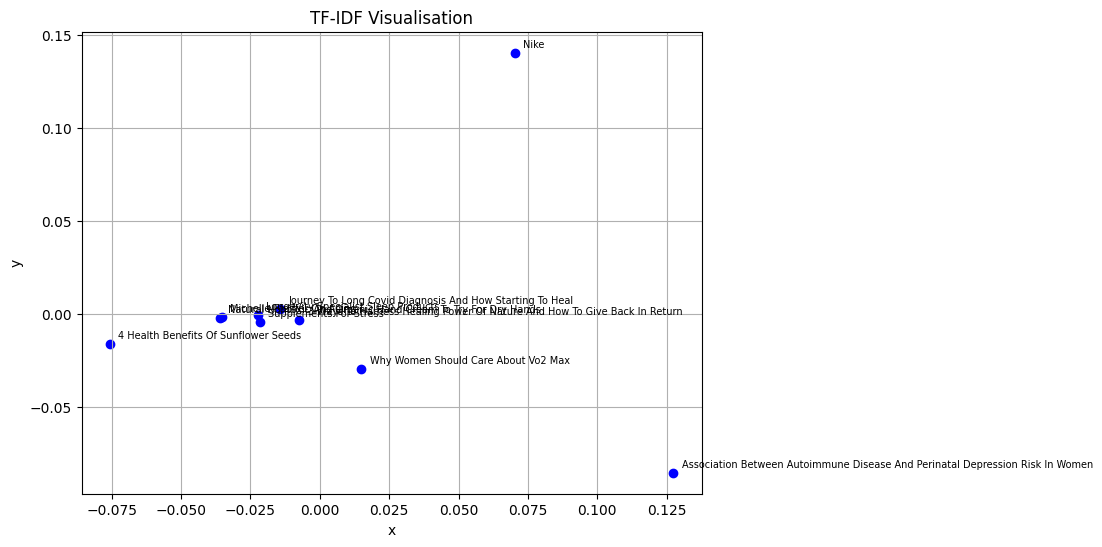

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # We keep 2 dimensions to construct the graph
tf_idf_2d = pca.fit_transform(tf_idf)  # Compute the vectors in 2 D

tf_idf_2d_df = pd.DataFrame(tf_idf_2d, columns=['x', 'y'], index=tf_idf.index)  # Compute a dataframe pandas
tf_idf_2d_df['label'] = tf_idf_2d_df.index.map(url_to_label)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(tf_idf_2d_df['x'], tf_idf_2d_df['y'], color='blue')

# To delete if we don't want the labels
for _, row in tf_idf_2d_df.iterrows():
    plt.text(row['x']+0.003, row['y']+0.003, row['label'], fontsize=7)

plt.title("TF-IDF Visualisation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


## Similarity Matrix

,https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max,https://www.mindbodygreen.com/articles/journey-to-long-covid-diagnosis-and-how-starting-to-heal,https://www.mindbodygreen.com/articles/supplements-for-stress,https://www.mindbodygreen.com/articles/longevity-specialist-sleep-products,https://www.mindbodygreen.com/articles/natural-nontoxic-and-organic-hand-cream-to-try-for-dry-hands,https://www.mindbodygreen.com/partner/nike,https://www.mindbodygreen.com/articles/4-health-benefits-of-sunflower-seeds,https://www.mindbodygreen.com/articles/michelle-pfeiffer-on-aging,https://www.mindbodygreen.com/articles/association-between-autoimmune-disease-and-perinatal-depression-risk-in-women,https://www.mindbodygreen.com/articles/3-ways-to-harness-healing-power-of-nature-and-how-to-give-back-in-return
https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max,1.000000,0.134848,0.138095,0.131055,0.090882,0.000000,0.106011,0.076831,0.400765,0.226215
https://www.mindbodygreen.com/articles/journey-to-long-covid-diagnosis-and-how-starting-to-heal,0.134848,1.000000,0.108709,0.115742,0.050584,0.037111,0.038109,0.152794,0.049678,0.114811
https://www.mindbodygreen.com/articles/supplements-for-stress,0.138095,0.108709,1.000000,0.142527,0.206902,0.000000,0.102036,0.093961,0.062207,0.189978
https://www.mindbodygreen.com/articles/longevity-specialist-sleep-products,0.131055,0.115742,0.142527,1.000000,0.105036,0.000000,0.036632,0.079078,0.021175,0.071635
https://www.mindbodygreen.com/articles/natural-nontoxic-and-organic-hand-cream-to-try-for-dry-hands,0.090882,0.050584,0.206902,0.105036,1.000000,0.010847,0.092463,0.255857,0.036209,0.070205
https://www.mindbodygreen.com/partner/nike,0.000000,0.037111,0.000000,0.000000,0.010847,1.000000,0.000000,0.000000,0.104286,0.045040
https://www.mindbodygreen.com/articles/4-health-benefits-of-sunflower-seeds,0.106011,0.038109,0.102036,0.036632,0.092463,0.000000,1.000000,0.044469,0.023607,0.057937
https://www.mindbodygreen.com/articles/michelle-pfeiffer-on-aging,0.076831,0.152794,0.093961,0.079078,0.255857,0.000000,0.044469,1.000000,0.029433,0.081458
https://www.mindbodygreen.com/articles/association-between-autoimmune-disease-and-perinatal-depression-risk-in-women,0.400765,0.049678,0.062207,0.021175,0.036209,0.104286,0.023607,0.029433,1.000000,0.113305
https://www.mindbodygreen.com/articles/3-ways-to-harness-healing-power-of-nature-and-how-to-give-back-in-return,0.226215,0.114811,0.189978,0.071635,0.070205,0.045040,0.057937,0.081458,0.113305,1.000000


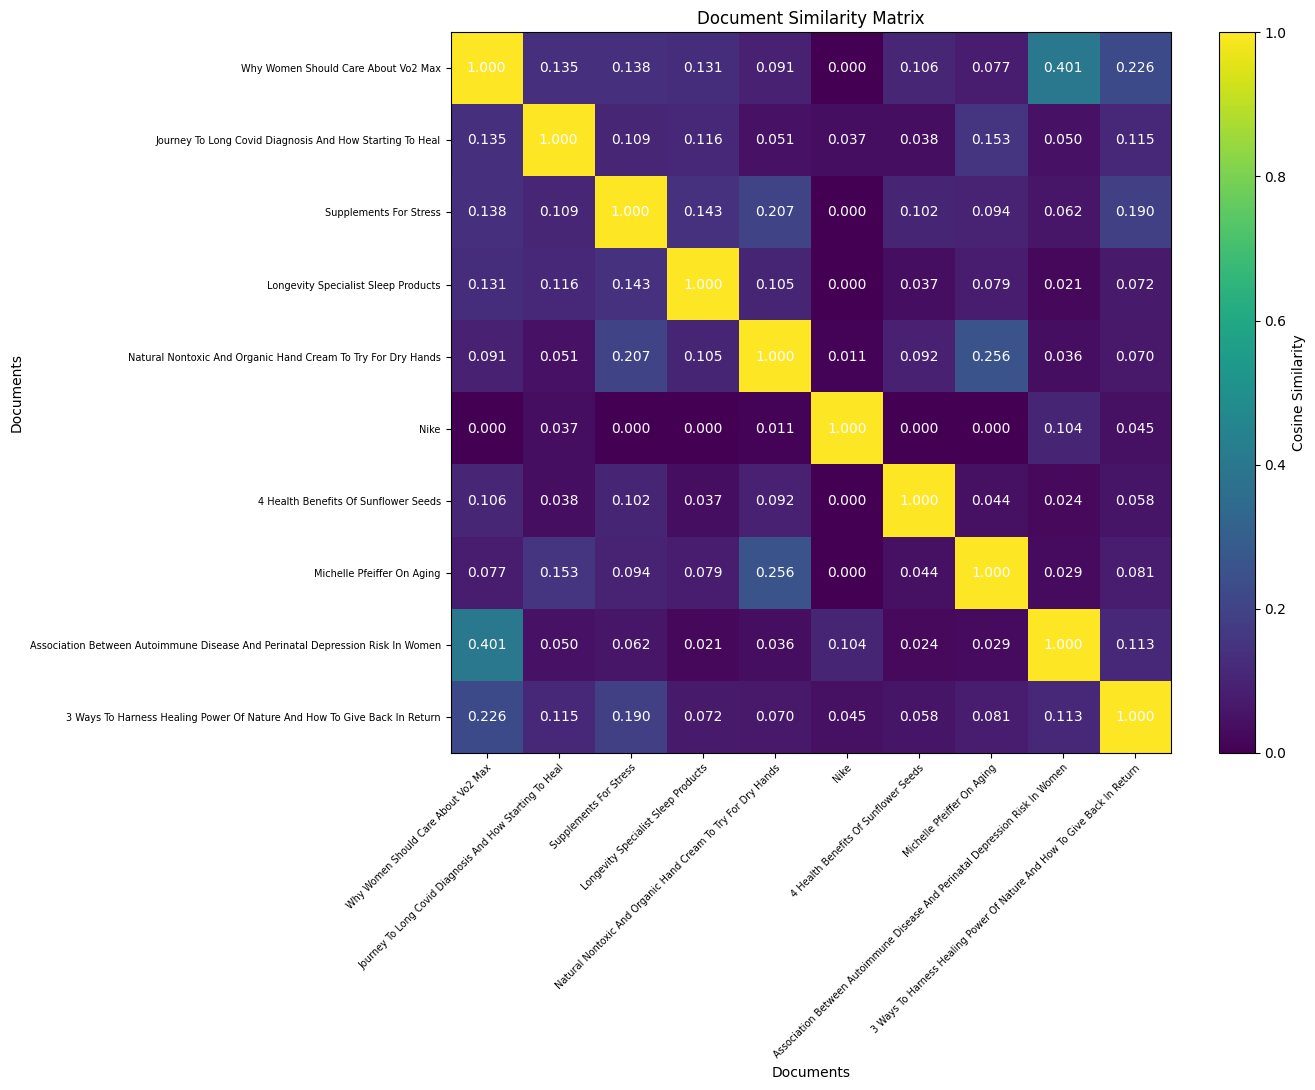

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix_tfidf = cosine_similarity(tf_idf)  # Each value ranges from 0 (no similarity) to 1 (identical documents).

# Convert to a DataFrame for better readability (optional)
similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf.index, columns=tf_idf.index)  # Rows and columns are labeled with document identifiers (index)

# Display the similarity DataFrame
display(similarity_df_tfidf)

def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    plt.figure(figsize=(14, 11))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')

    labels = [url_to_label(url) for url in similarity_df.columns]  # We labelized the document not with their full link but their label found with the function (url_to_label)
    
    ax = plt.gca()  # We set the axis to have them set at the right place
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels( labels, rotation=45, ha='right', rotation_mode='anchor', fontsize=7)
    ax.set_yticklabels( labels, fontsize=7)
    
    ax.set_xlabel('Documents')
    ax.set_ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            ax.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')

    plt.tight_layout()

plot_similarity_matrix(similarity_df_tfidf)

,https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max,https://www.mindbodygreen.com/articles/journey-to-long-covid-diagnosis-and-how-starting-to-heal,https://www.mindbodygreen.com/articles/supplements-for-stress,https://www.mindbodygreen.com/articles/longevity-specialist-sleep-products,https://www.mindbodygreen.com/articles/natural-nontoxic-and-organic-hand-cream-to-try-for-dry-hands,https://www.mindbodygreen.com/partner/nike,https://www.mindbodygreen.com/articles/4-health-benefits-of-sunflower-seeds,https://www.mindbodygreen.com/articles/michelle-pfeiffer-on-aging,https://www.mindbodygreen.com/articles/association-between-autoimmune-disease-and-perinatal-depression-risk-in-women,https://www.mindbodygreen.com/articles/3-ways-to-harness-healing-power-of-nature-and-how-to-give-back-in-return
https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max,1.000000,0.128050,0.139489,0.154696,0.094426,0.000000,0.126822,0.094499,0.379319,0.233208
https://www.mindbodygreen.com/articles/journey-to-long-covid-diagnosis-and-how-starting-to-heal,0.128050,1.000000,0.099088,0.114734,0.050062,0.037746,0.038281,0.154909,0.048302,0.117017
https://www.mindbodygreen.com/articles/supplements-for-stress,0.139489,0.099088,1.000000,0.143161,0.207884,0.000000,0.096788,0.098209,0.069660,0.211150
https://www.mindbodygreen.com/articles/longevity-specialist-sleep-products,0.154696,0.114734,0.143161,1.000000,0.099694,0.000000,0.071853,0.117821,0.019434,0.083569
https://www.mindbodygreen.com/articles/natural-nontoxic-and-organic-hand-cream-to-try-for-dry-hands,0.094426,0.050062,0.207884,0.099694,1.000000,0.011067,0.091469,0.255817,0.034035,0.071613
https://www.mindbodygreen.com/partner/nike,0.000000,0.037746,0.000000,0.000000,0.011067,1.000000,0.000000,0.000000,0.099768,0.046327
https://www.mindbodygreen.com/articles/4-health-benefits-of-sunflower-seeds,0.126822,0.038281,0.096788,0.071853,0.091469,0.000000,1.000000,0.068242,0.022371,0.063378
https://www.mindbodygreen.com/articles/michelle-pfeiffer-on-aging,0.094499,0.154909,0.098209,0.117821,0.255817,0.000000,0.068242,1.000000,0.028122,0.091065
https://www.mindbodygreen.com/articles/association-between-autoimmune-disease-and-perinatal-depression-risk-in-women,0.379319,0.048302,0.069660,0.019434,0.034035,0.099768,0.022371,0.028122,1.000000,0.133835
https://www.mindbodygreen.com/articles/3-ways-to-harness-healing-power-of-nature-and-how-to-give-back-in-return,0.233208,0.117017,0.211150,0.083569,0.071613,0.046327,0.063378,0.091065,0.133835,1.000000


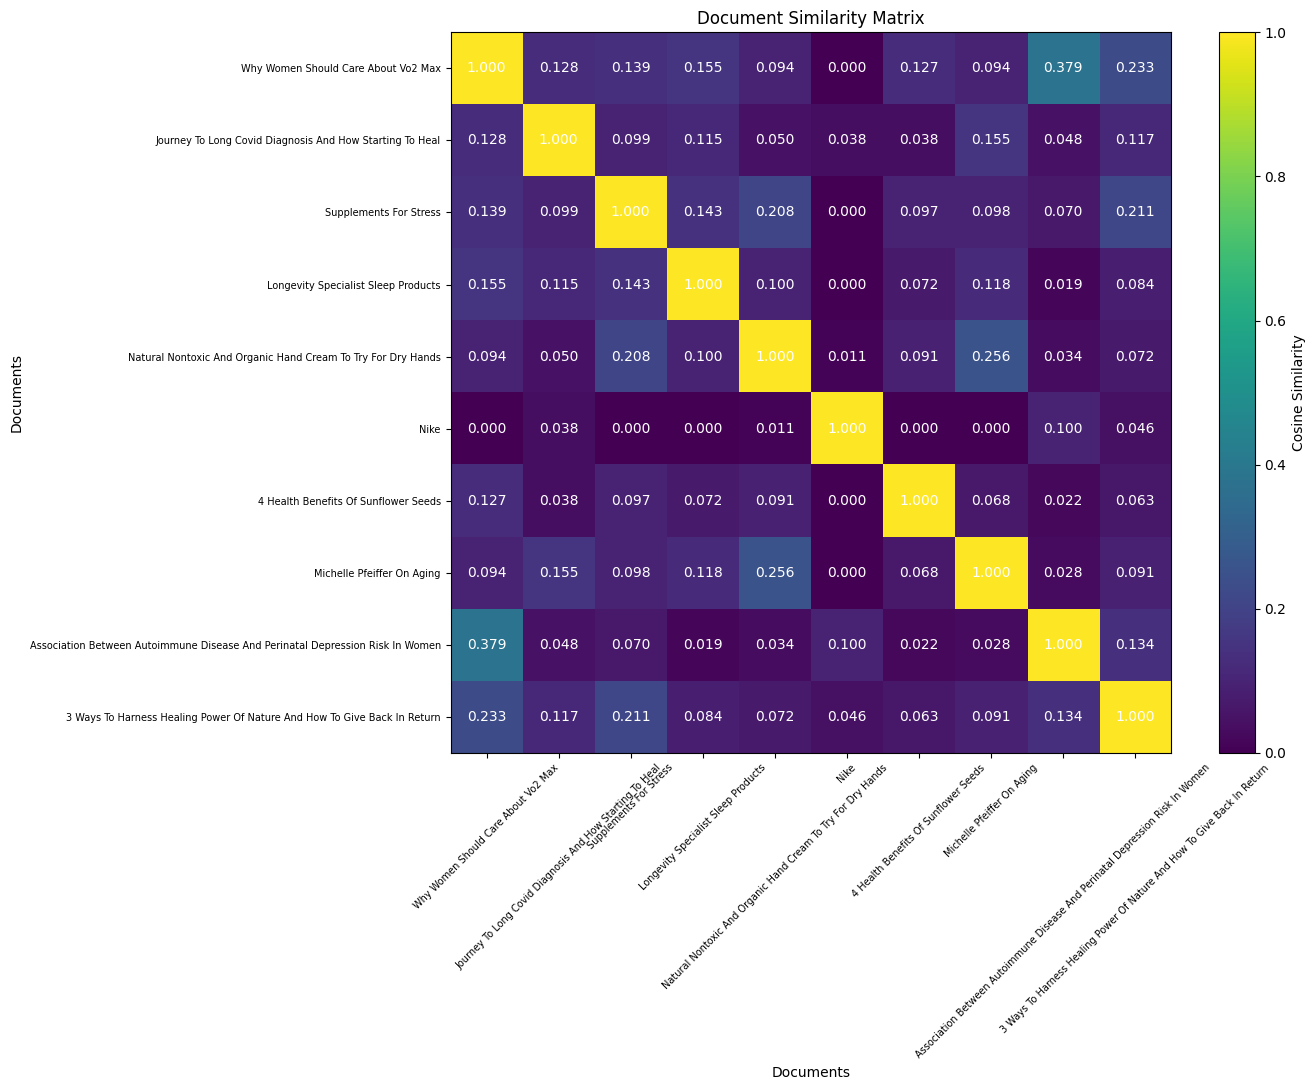

In [ ]:
# Sans les modifs de chat (= le code du prof) mais alors les axes déconne un peu

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix_tfidf = cosine_similarity(tf_idf)  # Each value ranges from 0 (no similarity) to 1 (identical documents).

# Convert to a DataFrame for better readability (optional)
similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf.index, columns=tf_idf.index)  # Rows and columns are labeled with document identifiers (index)

# Display the similarity DataFrame
display(similarity_df_tfidf)

def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    plt.figure(figsize=(14, 11))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')

    labels = [url_to_label(url) for url in similarity_df.columns]  # We labelized the document not with their full link but their label found with the function (url_to_label)
    
    plt.xticks(ticks=range(len(similarity_df.columns)), labels = labels, rotation=45, fontsize=7)  
    plt.yticks(ticks=range(len(similarity_df.index)), labels = labels, fontsize=7)
    plt.xlabel('Documents')
    plt.ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            plt.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')

    plt.tight_layout()

plot_similarity_matrix(similarity_df_tfidf)


## Most frequent words

In [131]:
from collections import Counter

all_tokens = [tok for tokens in tokenized_MBG_csv["tokenized_text"] for tok in tokens]  # Create a list with all the tokens

word_freq = Counter(all_tokens)  # Count the number of times a token appears in the list

word_freq.most_common(20)  # Print only the 20 most frequent

[('max', 46),
 ('stress', 46),
 ('vo', 45),
 ('body', 37),
 ('health', 37),
 ('fragrance', 37),
 ('help', 36),
 ('product', 35),
 ('woman', 34),
 ('hand', 34),
 ('ingredient', 33),
 ('supplement', 30),
 ('one', 28),
 ('disease', 26),
 ('mg', 26),
 ('way', 24),
 ('time', 23),
 ('plant', 23),
 ('cream', 23),
 ('sleep', 21)]

## Words cloud

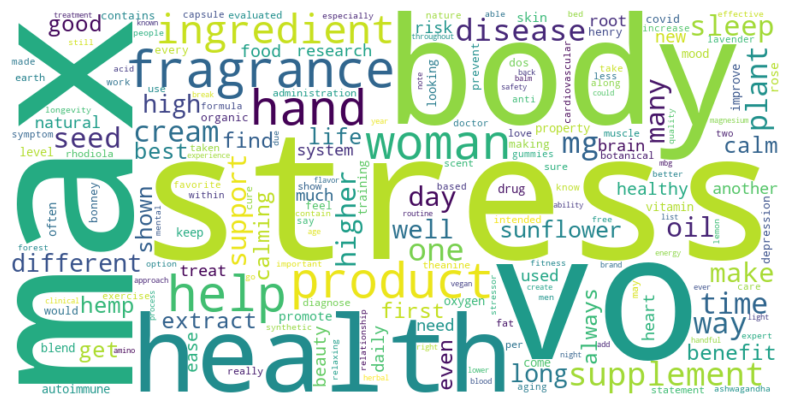

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud( width=900, height=450, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Concordance
#### A supprimer ?

In [ ]:
# A SUPPRIMER

def concordance(tokens, keyword, window=5):
    """
    Return a list of contexts where the keyword appears in the token list.
    Each context is a tuple: (left_context, keyword, right_context)
    """
    contexts = []
    for i, tok in enumerate(tokens):
        if tok == keyword:
            left = tokens[max(0, i-window):i]
            right = tokens[i+1:i+1+window]
            contexts.append((" ".join(left), keyword, " ".join(right)))
    return contexts

keyword = "stress"

for _, row in tokenized_MBG_csv.iterrows():
    # Ensure tokenized_text is a list of tokens
    tokens = row["tokenized_text"]
    if isinstance(tokens, str):
        # If stored as string, convert to list (split by space)
        tokens = tokens.split()
    for left, kw, right in concordance(tokens, keyword):
        print(f"[{row['url']}]")
        print(f"{left} >>{kw}<< {right}\n")


[https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max]
neurotrophic factor exercise link lower >>stress<< induce hormone cortisol support better

[https://www.mindbodygreen.com/articles/supplements-for-stress]
 >>stress<< like many thing life best

[https://www.mindbodygreen.com/articles/supplements-for-stress]
output body brain high level >>stress<< time wendy suzuki brain plasticity

[https://www.mindbodygreen.com/articles/supplements-for-stress]
york university tell mbg along >>stress<< relieve practice like exercise meditation

[https://www.mindbodygreen.com/articles/supplements-for-stress]
bring body back baseline relieve >>stress<< build problem society suzuki put

[https://www.mindbodygreen.com/articles/supplements-for-stress]
problem society suzuki put opt >>stress<< response constant external stimulation best

[https://www.mindbodygreen.com/articles/supplements-for-stress]
artificial sweetener synthetic dye include >>stress<< supplement prioritize quality

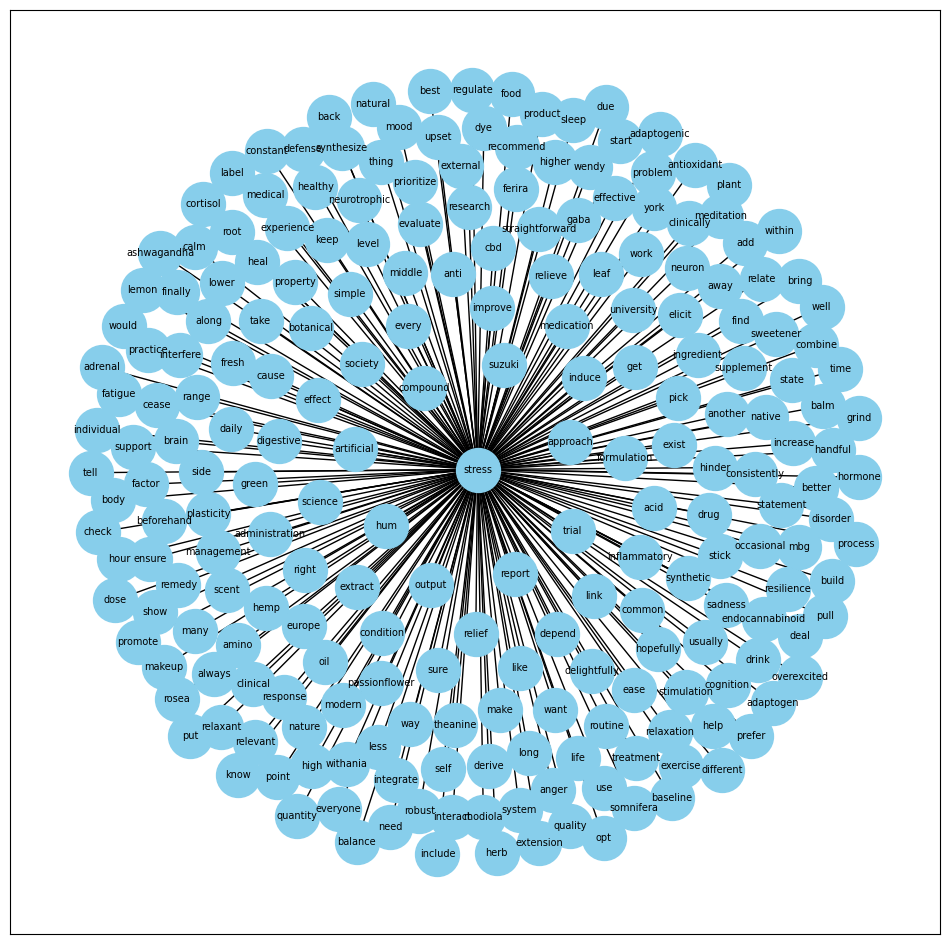

In [180]:
import networkx as nx

G = nx.Graph()

for _, row in tokenized_MBG_csv.iterrows():
    tokens = row["tokenized_text"]
    for left, kw, right in concordance(tokens, keyword):
        for word in left.split() + right.split():
            if word != kw:
                G.add_edge(kw, word)

plt.figure(figsize=(12,12))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=1000, font_size=7)
plt.show()


## Analyse temporelle avec LDA

In [133]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 6  # Define the number of topics you want the LDA model to extract from the documents.
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)  # Create an LDA (Latent Dirichlet Allocation) model instance. random_state = seed for reproducibility (ensures the same results each time)

lda_model.fit(MBG_td_matrix)  # LDA learns the topic distributions for each document and the word distributions for each topic. We use term-document matrix as the vector for the LDA matrix.

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",6
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [134]:
words = MBG_td_matrix.columns.tolist()  # Get the list of words (terms) corresponding to the columns of the td_matrix.
themes = {}  # Initialize an empty dictionary to store topics. Key = topic name (most frequent word), Value = set of top words for that topic.

for topic_idx, topic in enumerate(lda_model.components_):  # For each topic in the LDA model. lda_model.components_ is a matrix of shape (n_topics, n_words). Each row corresponds to a topic and contains the importance of each word for that topic.
    
    top_words_idx = topic.argsort()[::-1][:10]  # We keep only the 10 main words that have the most relevance (topic.argsort() sorts word indices in ascending order by their importance)
    top_words = [words[i] for i in top_words_idx]  # Convert the indices into actual word strings using the 'words' list.

    topic_name = top_words[0]  # We give a "name" to the topic (which is the most frequant word of the list)

    themes[topic_name] = set(top_words)  # Store the topic in the dictionary.

print(themes) 

for name, words_set in themes.items():
    print(f"{name}: {words_set}")  # For a clearer view of the topics and their corresponding words

{'seed': {'oil', 'seed', 'benefit', 'ingredient', 'vitamin', 'body', 'cream', 'one', 'skin', 'free'}, 'american': {'intended', 'drug', 'association', 'cure', 'administration', 'american', 'evaluated', 'diagnose', 'worldwide', 'statement'}, 'woman': {'oxygen', 'heart', 'woman', 'men', 'risk', 'disease', 'fat', 'body', 'health', 'higher'}, 'stress': {'sleep', 'stress', 'way', 'supplement', 'ease', 'help', 'promote', 'calming', 'plant', 'support'}, 'fragrance': {'new', 'really', 'first', 'product', 'ingredient', 'beauty', 'rose', 'time', 'health', 'fragrance'}}
seed: {'oil', 'seed', 'benefit', 'ingredient', 'vitamin', 'body', 'cream', 'one', 'skin', 'free'}
american: {'intended', 'drug', 'association', 'cure', 'administration', 'american', 'evaluated', 'diagnose', 'worldwide', 'statement'}
woman: {'oxygen', 'heart', 'woman', 'men', 'risk', 'disease', 'fat', 'body', 'health', 'higher'}
stress: {'sleep', 'stress', 'way', 'supplement', 'ease', 'help', 'promote', 'calming', 'plant', 'support'

seed


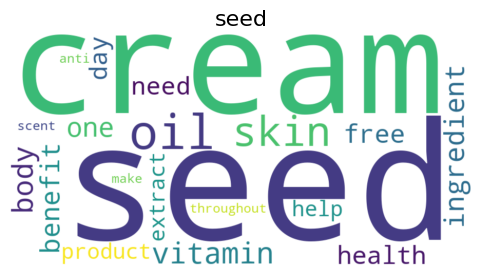

american


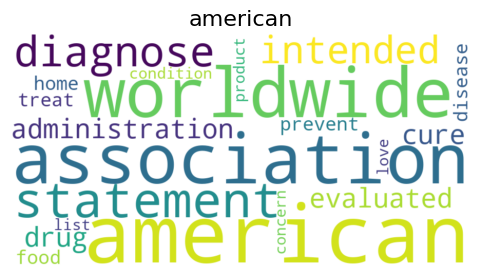

american


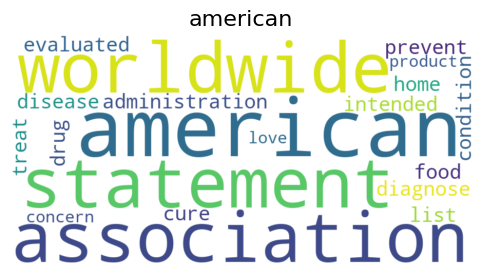

woman


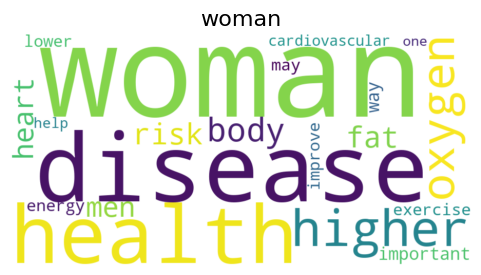

stress


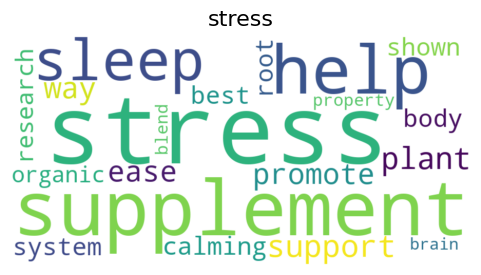

fragrance


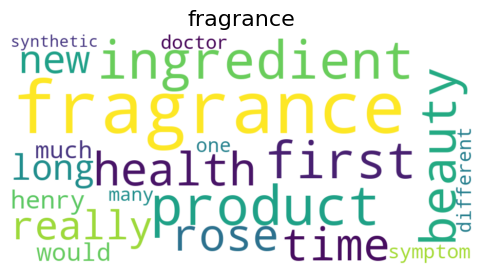

In [135]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Creates a Word cloud for every topic

words = MBG_td_matrix.columns.tolist()

for topic_idx, topic in enumerate(lda_model.components_):
    # Get the top words and their scores
    top_words_idx = topic.argsort()[::-1][:20]  # top 20 words
    top_words = [words[i] for i in top_words_idx]
    word_freq = {words[i]: topic[i] for i in top_words_idx}  # word -> importance

    topic_name = top_words[0]
    print(topic_name)

    # Create the WordCloud
    wc = WordCloud( width=900, height=450, background_color="white").generate_from_frequencies(word_freq)

    # Display the WordCloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topic_name, fontsize=16, color='black')  # Topic name at the top
    plt.show()


In [136]:
from collections import Counter

def count_themes(tokens, themes):  # Count the number of times a theme (or associated word) appears in each document (/ doc's tokens)
    counts = Counter()
    token_set = set(tokens)
    for theme, keywords in themes.items():
        counts[theme] = len(token_set & keywords)
    return counts

In [137]:
timeline_MBG = tokenized_MBG_csv.copy()  # To be safer, we creat a copy of the dataframe
timeline_MBG ['date'] = pd.to_datetime(timeline_MBG['date'], errors='coerce')  # Transforms the dates into correct dates frame and if the data is not convertible it becomes "Not a Time"
timeline_MBG = timeline_MBG.dropna(subset=['date'])  # Delete all rows whith unvalid dates

In [138]:
rows = []

for i, row in timeline_MBG.iterrows():  # For every line in the dataframe (timeline_MBG)
    tokens = row['tokenized_text']  # Collect the tokens in the correct column

    theme_counts = count_themes(tokens, themes)  # Count the number of times the theme appears in the article's tokens

    for theme, count in theme_counts.items():  # For every theme and number of times it appears
        rows.append({ "date": row['date'],  "theme": theme, "count": count })  # Construction of a dictionnary for each date and for each theme and the number of times it appears

theme_timeline_MBG = pd.DataFrame(rows)  # Transform the list of dictionaaries in a dataframe

In [139]:
daily_evolution_timeline_MBG = ( theme_timeline_MBG
    .groupby(['date', 'theme'])['count']  # Group the datas (theme_timeline_MBG) according to their date and theme
    .sum()  # If multiples rows of theme_timeline_MBG has the same group (= same date and theme) it is sum to form only one row
    .reset_index()  # Important to not have the columns changed into date, theme (which is done automatically by groupby)
)

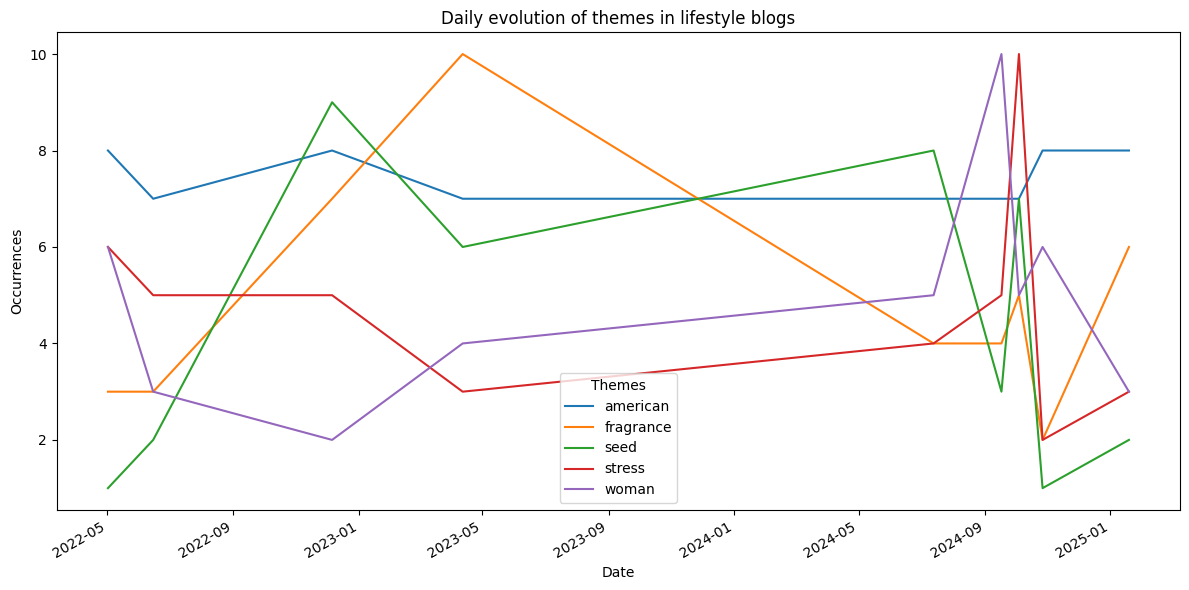

In [140]:
import matplotlib.pyplot as plt

# Pivot par jour
pivot = ( daily_evolution_timeline_MBG .pivot(index='date', columns='theme', values='count') .fillna(0))  # We pivot the table

# Plot
pivot.plot(figsize=(12,6))
plt.title("Daily evolution of themes in lifestyle blogs")
plt.xlabel("Date")
plt.ylabel("Occurrences")
plt.legend(title="Themes")
plt.tight_layout()
plt.show()


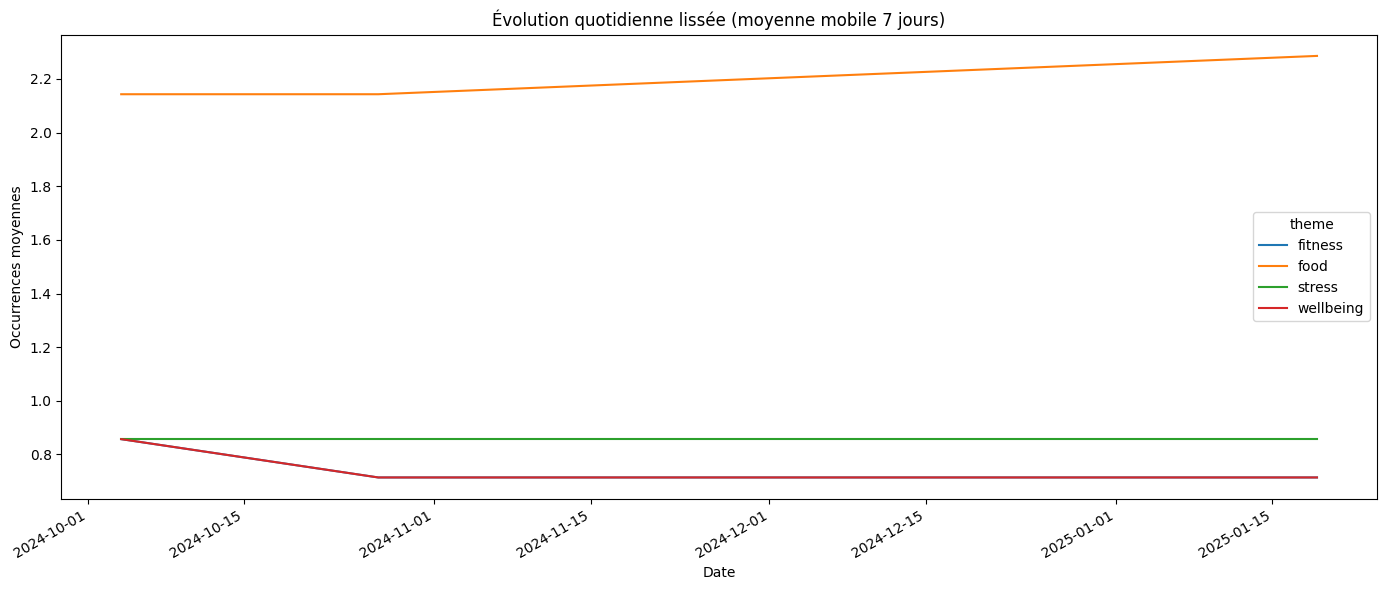

In [ ]:
# Lissage par moyenne mobile sur 7 jours  -> A supprimer
daily_smoothed = pivot.rolling(window=7).mean()

daily_smoothed.plot(figsize=(14,6))
plt.title("Évolution quotidienne lissée (moyenne mobile 7 jours)")
plt.xlabel("Date")
plt.ylabel("Occurrences moyennes")
plt.tight_layout()
plt.show()
